# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

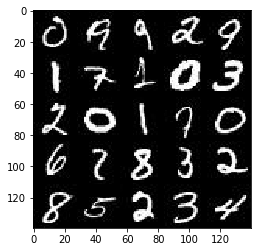

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

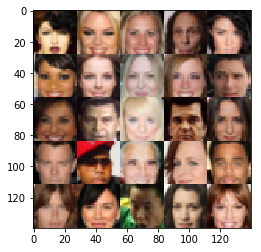

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input')
    z = tf.placeholder(tf.float32, shape=[None, z_dim], name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        output = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d(output, 64, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=True)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d(output, 128, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=True)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d(output, 256, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=True)
        output = tf.maximum(alpha * output, output)
        
        output = tf.reshape(output, (-1, 4*4*256))
        
        logits = tf.layers.dense(output, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        output = tf.layers.dense(z, 4*4*512)
        
        output = tf.reshape(output, (-1, 4, 4, 512))
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d_transpose(output, 128, 4, strides=1, padding='valid')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d_transpose(output, 64, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        output = tf.layers.conv2d_transpose(output, 32, 5, strides=2, padding='same')
        output = tf.layers.batch_normalization(output, training=is_train)
        output = tf.maximum(alpha * output, output)
        
        logits = tf.layers.conv2d_transpose(output, out_channel_dim, 3, strides=1, padding='same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Smoothing 
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * (1 - smooth)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_t, z_t, learning_rate_t = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_t, z_t, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_t, beta1)
    
    step = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                
                random_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Discriminator
                _ = sess.run(
                    d_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                # Generator
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                # To avoid the fast convergence of D (discriminator) network, G (generator) network is updated twice for each D network update
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_t: batch_images,
                        z_t: random_noise,
                        learning_rate_t: learning_rate
                    }
                )
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({
                        z_t: random_noise,
                        input_t: batch_images
                    })
                    
                    train_loss_g = g_loss.eval({
                        z_t: random_noise
                    })
                    
                    print(
                        "Epoch {}/{}".format(epoch_i + 1, epoch_count),
                        "Discriminator Loss: {:.4f}".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    losses.append((train_loss_d, train_loss_g))
                    
                if step % 100 == 0:
                    show_generator_output(sess, 7**2, z_t, image_channels, data_image_mode)
                    
        pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
        pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
        pyplot.title('Training Losses')
        pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss: 3.5355 Generator Loss: 0.0505
Epoch 1/2 Discriminator Loss: 2.9296 Generator Loss: 0.1060
Epoch 1/2 Discriminator Loss: 2.9140 Generator Loss: 0.1201
Epoch 1/2 Discriminator Loss: 3.0594 Generator Loss: 0.1224
Epoch 1/2 Discriminator Loss: 2.2125 Generator Loss: 0.2966
Epoch 1/2 Discriminator Loss: 2.0227 Generator Loss: 0.2909
Epoch 1/2 Discriminator Loss: 1.3157 Generator Loss: 0.5844
Epoch 1/2 Discriminator Loss: 1.5824 Generator Loss: 0.6091
Epoch 1/2 Discriminator Loss: 1.8959 Generator Loss: 0.2613
Epoch 1/2 Discriminator Loss: 1.9101 Generator Loss: 0.3075


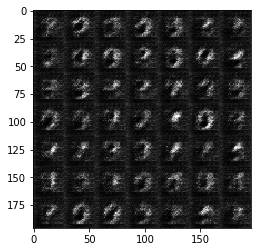

Epoch 1/2 Discriminator Loss: 1.9042 Generator Loss: 0.3620
Epoch 1/2 Discriminator Loss: 1.6373 Generator Loss: 0.6560
Epoch 1/2 Discriminator Loss: 1.7214 Generator Loss: 0.3657
Epoch 1/2 Discriminator Loss: 1.7248 Generator Loss: 0.4146
Epoch 1/2 Discriminator Loss: 1.4627 Generator Loss: 0.5388
Epoch 1/2 Discriminator Loss: 1.2240 Generator Loss: 0.7384
Epoch 1/2 Discriminator Loss: 1.3510 Generator Loss: 0.6481
Epoch 1/2 Discriminator Loss: 1.4607 Generator Loss: 0.6958
Epoch 1/2 Discriminator Loss: 1.5586 Generator Loss: 0.4457
Epoch 1/2 Discriminator Loss: 1.3556 Generator Loss: 0.5932


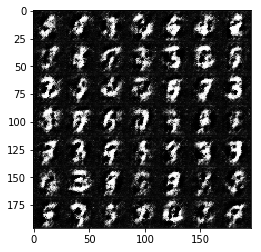

Epoch 1/2 Discriminator Loss: 1.5495 Generator Loss: 0.9336
Epoch 1/2 Discriminator Loss: 1.5843 Generator Loss: 0.3926
Epoch 1/2 Discriminator Loss: 1.5998 Generator Loss: 0.4129
Epoch 1/2 Discriminator Loss: 1.5446 Generator Loss: 0.4121
Epoch 1/2 Discriminator Loss: 1.3776 Generator Loss: 0.5143
Epoch 1/2 Discriminator Loss: 1.5287 Generator Loss: 0.5067
Epoch 1/2 Discriminator Loss: 1.5944 Generator Loss: 0.3801
Epoch 1/2 Discriminator Loss: 1.3247 Generator Loss: 0.5277
Epoch 1/2 Discriminator Loss: 1.2704 Generator Loss: 0.6173
Epoch 1/2 Discriminator Loss: 1.4318 Generator Loss: 0.4743


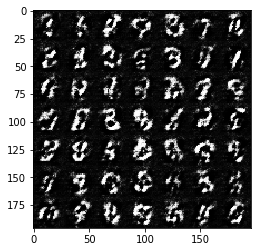

Epoch 1/2 Discriminator Loss: 1.3205 Generator Loss: 0.5530
Epoch 1/2 Discriminator Loss: 1.2440 Generator Loss: 0.7936
Epoch 1/2 Discriminator Loss: 1.4621 Generator Loss: 0.4914
Epoch 1/2 Discriminator Loss: 1.5316 Generator Loss: 0.3886
Epoch 1/2 Discriminator Loss: 1.2040 Generator Loss: 0.8720
Epoch 1/2 Discriminator Loss: 1.5732 Generator Loss: 0.4488
Epoch 1/2 Discriminator Loss: 1.3295 Generator Loss: 0.6446
Epoch 1/2 Discriminator Loss: 1.5429 Generator Loss: 0.4056
Epoch 1/2 Discriminator Loss: 1.1698 Generator Loss: 0.8801
Epoch 1/2 Discriminator Loss: 1.3093 Generator Loss: 0.7050


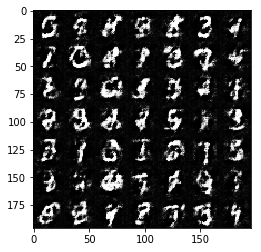

Epoch 1/2 Discriminator Loss: 1.4152 Generator Loss: 0.4771
Epoch 1/2 Discriminator Loss: 1.2259 Generator Loss: 0.8333
Epoch 1/2 Discriminator Loss: 1.3661 Generator Loss: 0.6695
Epoch 1/2 Discriminator Loss: 1.6006 Generator Loss: 0.3590
Epoch 1/2 Discriminator Loss: 1.3863 Generator Loss: 0.6722
Epoch 1/2 Discriminator Loss: 1.3436 Generator Loss: 0.6469
Epoch 1/2 Discriminator Loss: 1.4012 Generator Loss: 0.6859
Epoch 1/2 Discriminator Loss: 1.7376 Generator Loss: 0.3015
Epoch 1/2 Discriminator Loss: 1.8335 Generator Loss: 0.2901
Epoch 1/2 Discriminator Loss: 1.8907 Generator Loss: 0.2474


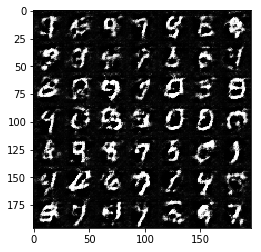

Epoch 1/2 Discriminator Loss: 1.2897 Generator Loss: 0.7425
Epoch 1/2 Discriminator Loss: 1.2107 Generator Loss: 0.7478
Epoch 1/2 Discriminator Loss: 1.6020 Generator Loss: 0.3824
Epoch 1/2 Discriminator Loss: 1.2341 Generator Loss: 0.6717
Epoch 1/2 Discriminator Loss: 1.3727 Generator Loss: 0.5341
Epoch 1/2 Discriminator Loss: 1.5526 Generator Loss: 0.4011
Epoch 1/2 Discriminator Loss: 1.4897 Generator Loss: 1.4963
Epoch 1/2 Discriminator Loss: 1.6364 Generator Loss: 0.3632
Epoch 1/2 Discriminator Loss: 1.6081 Generator Loss: 0.3721
Epoch 1/2 Discriminator Loss: 1.3730 Generator Loss: 0.5886


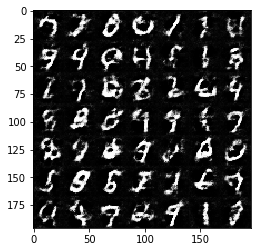

Epoch 1/2 Discriminator Loss: 1.2565 Generator Loss: 0.8777
Epoch 1/2 Discriminator Loss: 1.6014 Generator Loss: 0.3942
Epoch 1/2 Discriminator Loss: 1.3606 Generator Loss: 0.7423
Epoch 1/2 Discriminator Loss: 1.5905 Generator Loss: 0.4129
Epoch 1/2 Discriminator Loss: 1.8491 Generator Loss: 0.2685
Epoch 1/2 Discriminator Loss: 1.4499 Generator Loss: 0.4682
Epoch 1/2 Discriminator Loss: 1.5088 Generator Loss: 0.8193
Epoch 1/2 Discriminator Loss: 1.4797 Generator Loss: 0.4903
Epoch 1/2 Discriminator Loss: 1.3181 Generator Loss: 0.5743
Epoch 1/2 Discriminator Loss: 1.2347 Generator Loss: 0.8430


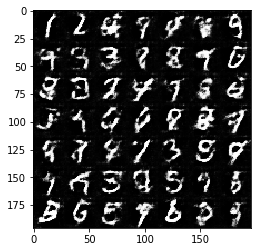

Epoch 1/2 Discriminator Loss: 1.4355 Generator Loss: 0.4763
Epoch 1/2 Discriminator Loss: 1.4489 Generator Loss: 0.8428
Epoch 1/2 Discriminator Loss: 1.5186 Generator Loss: 0.4290
Epoch 1/2 Discriminator Loss: 1.6761 Generator Loss: 0.3935
Epoch 1/2 Discriminator Loss: 1.4582 Generator Loss: 0.6380
Epoch 1/2 Discriminator Loss: 1.4638 Generator Loss: 0.4509
Epoch 1/2 Discriminator Loss: 1.3219 Generator Loss: 0.5401
Epoch 1/2 Discriminator Loss: 1.4842 Generator Loss: 0.4661
Epoch 1/2 Discriminator Loss: 1.3654 Generator Loss: 0.6416
Epoch 1/2 Discriminator Loss: 1.2938 Generator Loss: 1.0227


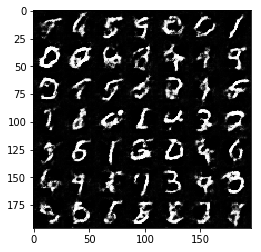

Epoch 1/2 Discriminator Loss: 1.3179 Generator Loss: 0.8284
Epoch 1/2 Discriminator Loss: 1.3583 Generator Loss: 0.6096
Epoch 1/2 Discriminator Loss: 1.2089 Generator Loss: 0.7507
Epoch 1/2 Discriminator Loss: 1.4488 Generator Loss: 0.8809
Epoch 1/2 Discriminator Loss: 1.4506 Generator Loss: 0.5542
Epoch 1/2 Discriminator Loss: 1.1716 Generator Loss: 0.9724
Epoch 1/2 Discriminator Loss: 1.6831 Generator Loss: 0.3431
Epoch 1/2 Discriminator Loss: 1.1886 Generator Loss: 0.8185
Epoch 1/2 Discriminator Loss: 1.4169 Generator Loss: 0.7617
Epoch 1/2 Discriminator Loss: 1.3089 Generator Loss: 0.8047


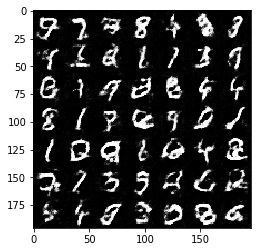

Epoch 1/2 Discriminator Loss: 1.5104 Generator Loss: 0.4922
Epoch 1/2 Discriminator Loss: 1.3595 Generator Loss: 0.5431
Epoch 1/2 Discriminator Loss: 1.3805 Generator Loss: 0.7322
Epoch 2/2 Discriminator Loss: 1.2171 Generator Loss: 0.7012
Epoch 2/2 Discriminator Loss: 1.3439 Generator Loss: 0.7475
Epoch 2/2 Discriminator Loss: 1.8457 Generator Loss: 0.2698
Epoch 2/2 Discriminator Loss: 1.4579 Generator Loss: 0.4732
Epoch 2/2 Discriminator Loss: 1.3125 Generator Loss: 0.6824
Epoch 2/2 Discriminator Loss: 1.4003 Generator Loss: 0.7299
Epoch 2/2 Discriminator Loss: 1.4848 Generator Loss: 0.4655


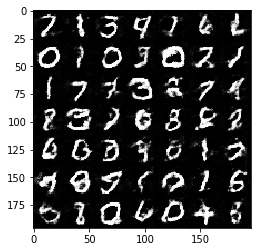

Epoch 2/2 Discriminator Loss: 1.3936 Generator Loss: 0.5314
Epoch 2/2 Discriminator Loss: 1.4174 Generator Loss: 0.5274
Epoch 2/2 Discriminator Loss: 1.2788 Generator Loss: 0.6346
Epoch 2/2 Discriminator Loss: 1.6195 Generator Loss: 0.4812
Epoch 2/2 Discriminator Loss: 1.7621 Generator Loss: 0.2949
Epoch 2/2 Discriminator Loss: 1.6343 Generator Loss: 0.3748
Epoch 2/2 Discriminator Loss: 1.1421 Generator Loss: 0.9807
Epoch 2/2 Discriminator Loss: 1.5514 Generator Loss: 0.4103
Epoch 2/2 Discriminator Loss: 1.5389 Generator Loss: 0.4049
Epoch 2/2 Discriminator Loss: 1.5185 Generator Loss: 0.4782


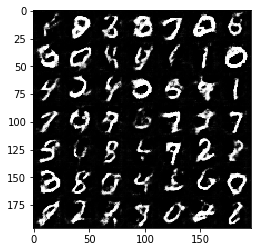

Epoch 2/2 Discriminator Loss: 1.3324 Generator Loss: 0.5727
Epoch 2/2 Discriminator Loss: 1.2497 Generator Loss: 0.9728
Epoch 2/2 Discriminator Loss: 1.2250 Generator Loss: 0.7492
Epoch 2/2 Discriminator Loss: 1.4930 Generator Loss: 0.4594
Epoch 2/2 Discriminator Loss: 1.5855 Generator Loss: 0.3722
Epoch 2/2 Discriminator Loss: 1.3939 Generator Loss: 0.5632
Epoch 2/2 Discriminator Loss: 1.2972 Generator Loss: 0.9159
Epoch 2/2 Discriminator Loss: 1.2807 Generator Loss: 0.6176
Epoch 2/2 Discriminator Loss: 1.4730 Generator Loss: 0.6621
Epoch 2/2 Discriminator Loss: 1.3983 Generator Loss: 0.4870


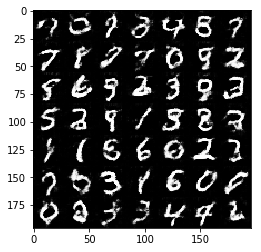

Epoch 2/2 Discriminator Loss: 1.3460 Generator Loss: 0.8240
Epoch 2/2 Discriminator Loss: 1.5109 Generator Loss: 0.5464
Epoch 2/2 Discriminator Loss: 1.5639 Generator Loss: 0.3693
Epoch 2/2 Discriminator Loss: 1.5065 Generator Loss: 0.4884
Epoch 2/2 Discriminator Loss: 1.5724 Generator Loss: 0.4628
Epoch 2/2 Discriminator Loss: 1.5507 Generator Loss: 0.4224
Epoch 2/2 Discriminator Loss: 1.3896 Generator Loss: 0.7683
Epoch 2/2 Discriminator Loss: 1.3334 Generator Loss: 0.5377
Epoch 2/2 Discriminator Loss: 1.5168 Generator Loss: 0.4343
Epoch 2/2 Discriminator Loss: 1.2064 Generator Loss: 0.9533


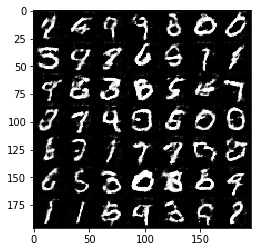

Epoch 2/2 Discriminator Loss: 1.5242 Generator Loss: 0.4332
Epoch 2/2 Discriminator Loss: 1.3472 Generator Loss: 0.6063
Epoch 2/2 Discriminator Loss: 1.5255 Generator Loss: 0.5070
Epoch 2/2 Discriminator Loss: 1.8692 Generator Loss: 0.2657
Epoch 2/2 Discriminator Loss: 1.5906 Generator Loss: 0.6545
Epoch 2/2 Discriminator Loss: 1.5871 Generator Loss: 0.4250
Epoch 2/2 Discriminator Loss: 1.4654 Generator Loss: 0.7111
Epoch 2/2 Discriminator Loss: 1.7657 Generator Loss: 0.3172
Epoch 2/2 Discriminator Loss: 1.4403 Generator Loss: 0.4833
Epoch 2/2 Discriminator Loss: 1.3529 Generator Loss: 0.7498


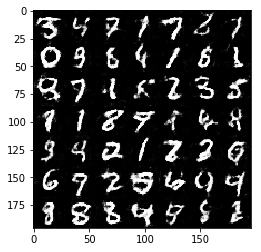

Epoch 2/2 Discriminator Loss: 1.5904 Generator Loss: 0.3980
Epoch 2/2 Discriminator Loss: 1.6869 Generator Loss: 0.3667
Epoch 2/2 Discriminator Loss: 1.5107 Generator Loss: 0.7490
Epoch 2/2 Discriminator Loss: 1.8301 Generator Loss: 0.2771
Epoch 2/2 Discriminator Loss: 1.5132 Generator Loss: 0.4623
Epoch 2/2 Discriminator Loss: 1.3665 Generator Loss: 0.6969
Epoch 2/2 Discriminator Loss: 1.9382 Generator Loss: 0.2688
Epoch 2/2 Discriminator Loss: 1.3644 Generator Loss: 0.5572
Epoch 2/2 Discriminator Loss: 1.4694 Generator Loss: 0.5476
Epoch 2/2 Discriminator Loss: 1.6067 Generator Loss: 0.4238


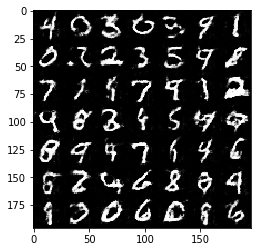

Epoch 2/2 Discriminator Loss: 1.8101 Generator Loss: 0.2828
Epoch 2/2 Discriminator Loss: 1.6063 Generator Loss: 0.4516
Epoch 2/2 Discriminator Loss: 1.4743 Generator Loss: 0.4216
Epoch 2/2 Discriminator Loss: 1.5261 Generator Loss: 0.5932
Epoch 2/2 Discriminator Loss: 1.8532 Generator Loss: 0.2657
Epoch 2/2 Discriminator Loss: 1.4573 Generator Loss: 0.4385
Epoch 2/2 Discriminator Loss: 1.3112 Generator Loss: 0.7276
Epoch 2/2 Discriminator Loss: 1.4589 Generator Loss: 0.5004
Epoch 2/2 Discriminator Loss: 1.4028 Generator Loss: 0.7679
Epoch 2/2 Discriminator Loss: 1.6283 Generator Loss: 0.3620


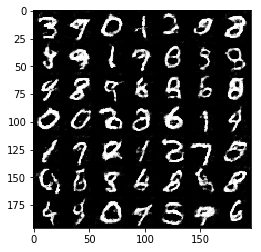

Epoch 2/2 Discriminator Loss: 1.3344 Generator Loss: 0.8163
Epoch 2/2 Discriminator Loss: 1.4781 Generator Loss: 0.4774
Epoch 2/2 Discriminator Loss: 1.5762 Generator Loss: 0.4247
Epoch 2/2 Discriminator Loss: 1.3960 Generator Loss: 0.6773
Epoch 2/2 Discriminator Loss: 1.4264 Generator Loss: 0.6101
Epoch 2/2 Discriminator Loss: 1.5441 Generator Loss: 0.4880
Epoch 2/2 Discriminator Loss: 1.4482 Generator Loss: 0.5066
Epoch 2/2 Discriminator Loss: 1.5477 Generator Loss: 0.6038
Epoch 2/2 Discriminator Loss: 1.7927 Generator Loss: 0.2850
Epoch 2/2 Discriminator Loss: 2.0552 Generator Loss: 0.2337


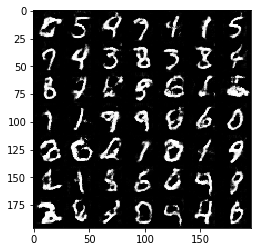

Epoch 2/2 Discriminator Loss: 1.6668 Generator Loss: 0.3368
Epoch 2/2 Discriminator Loss: 1.7005 Generator Loss: 0.3252
Epoch 2/2 Discriminator Loss: 1.6458 Generator Loss: 0.3393
Epoch 2/2 Discriminator Loss: 1.5589 Generator Loss: 0.4793
Epoch 2/2 Discriminator Loss: 1.3026 Generator Loss: 0.8907
Epoch 2/2 Discriminator Loss: 1.7876 Generator Loss: 0.3340
Epoch 2/2 Discriminator Loss: 1.4046 Generator Loss: 0.6194
Epoch 2/2 Discriminator Loss: 1.5552 Generator Loss: 0.4459
Epoch 2/2 Discriminator Loss: 1.2329 Generator Loss: 0.7049
Epoch 2/2 Discriminator Loss: 1.8535 Generator Loss: 0.2823


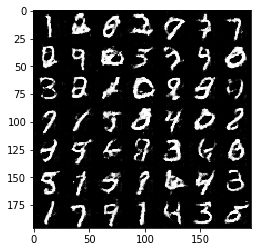

Epoch 2/2 Discriminator Loss: 1.7689 Generator Loss: 0.3216
Epoch 2/2 Discriminator Loss: 1.7920 Generator Loss: 0.3006
Epoch 2/2 Discriminator Loss: 1.4309 Generator Loss: 0.5134
Epoch 2/2 Discriminator Loss: 1.1333 Generator Loss: 1.0225
Epoch 2/2 Discriminator Loss: 1.5916 Generator Loss: 0.9681
Epoch 2/2 Discriminator Loss: 1.4093 Generator Loss: 0.8002
Epoch 2/2 Discriminator Loss: 1.6509 Generator Loss: 0.4222


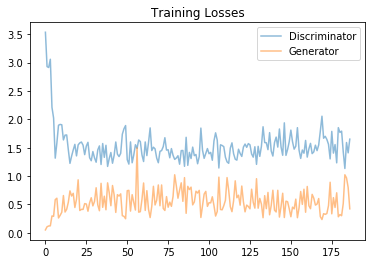

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss: 1.7663 Generator Loss: 0.4474
Epoch 1/1 Discriminator Loss: 1.4919 Generator Loss: 0.5814
Epoch 1/1 Discriminator Loss: 1.4197 Generator Loss: 0.6162
Epoch 1/1 Discriminator Loss: 1.3526 Generator Loss: 0.6705
Epoch 1/1 Discriminator Loss: 1.1394 Generator Loss: 0.9066
Epoch 1/1 Discriminator Loss: 1.0179 Generator Loss: 1.0209
Epoch 1/1 Discriminator Loss: 0.9835 Generator Loss: 0.9959
Epoch 1/1 Discriminator Loss: 1.0103 Generator Loss: 1.0244
Epoch 1/1 Discriminator Loss: 1.0619 Generator Loss: 0.9493
Epoch 1/1 Discriminator Loss: 0.9319 Generator Loss: 1.1424


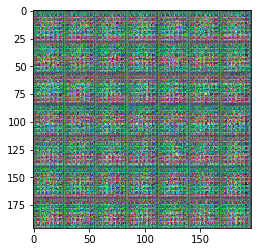

Epoch 1/1 Discriminator Loss: 0.8599 Generator Loss: 1.2333
Epoch 1/1 Discriminator Loss: 0.8696 Generator Loss: 1.2972
Epoch 1/1 Discriminator Loss: 0.8371 Generator Loss: 1.2754
Epoch 1/1 Discriminator Loss: 0.7847 Generator Loss: 1.2358
Epoch 1/1 Discriminator Loss: 0.8776 Generator Loss: 1.3106
Epoch 1/1 Discriminator Loss: 0.8770 Generator Loss: 1.2842
Epoch 1/1 Discriminator Loss: 0.8542 Generator Loss: 1.2878
Epoch 1/1 Discriminator Loss: 0.8623 Generator Loss: 1.2965
Epoch 1/1 Discriminator Loss: 0.8665 Generator Loss: 1.3428
Epoch 1/1 Discriminator Loss: 0.7473 Generator Loss: 1.4710


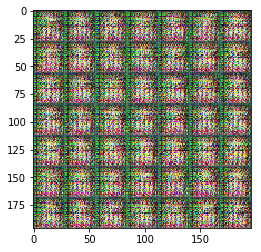

Epoch 1/1 Discriminator Loss: 0.7495 Generator Loss: 1.5034
Epoch 1/1 Discriminator Loss: 0.7602 Generator Loss: 1.3944
Epoch 1/1 Discriminator Loss: 0.7651 Generator Loss: 1.4067
Epoch 1/1 Discriminator Loss: 0.8993 Generator Loss: 1.2585
Epoch 1/1 Discriminator Loss: 0.8468 Generator Loss: 1.2464
Epoch 1/1 Discriminator Loss: 0.8560 Generator Loss: 1.3597
Epoch 1/1 Discriminator Loss: 0.7145 Generator Loss: 1.5361
Epoch 1/1 Discriminator Loss: 0.7791 Generator Loss: 1.4554
Epoch 1/1 Discriminator Loss: 0.7085 Generator Loss: 1.4925
Epoch 1/1 Discriminator Loss: 0.7750 Generator Loss: 1.4671


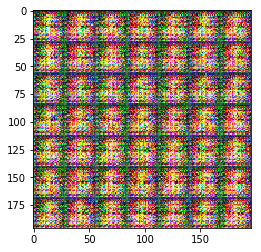

Epoch 1/1 Discriminator Loss: 0.6521 Generator Loss: 1.7715
Epoch 1/1 Discriminator Loss: 0.6515 Generator Loss: 1.7133
Epoch 1/1 Discriminator Loss: 0.7599 Generator Loss: 1.5814
Epoch 1/1 Discriminator Loss: 0.7081 Generator Loss: 1.6502
Epoch 1/1 Discriminator Loss: 0.6748 Generator Loss: 1.6448
Epoch 1/1 Discriminator Loss: 0.7582 Generator Loss: 1.4596
Epoch 1/1 Discriminator Loss: 0.7007 Generator Loss: 1.6638
Epoch 1/1 Discriminator Loss: 0.6576 Generator Loss: 1.6557
Epoch 1/1 Discriminator Loss: 0.5770 Generator Loss: 1.9792
Epoch 1/1 Discriminator Loss: 0.6998 Generator Loss: 1.7240


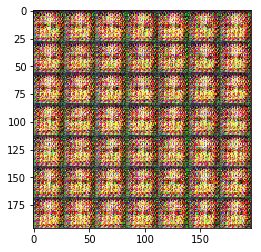

Epoch 1/1 Discriminator Loss: 0.6197 Generator Loss: 1.7604
Epoch 1/1 Discriminator Loss: 0.6844 Generator Loss: 1.6699
Epoch 1/1 Discriminator Loss: 0.6325 Generator Loss: 1.7921
Epoch 1/1 Discriminator Loss: 0.5917 Generator Loss: 1.9383
Epoch 1/1 Discriminator Loss: 0.5744 Generator Loss: 1.8796
Epoch 1/1 Discriminator Loss: 0.6686 Generator Loss: 1.7810
Epoch 1/1 Discriminator Loss: 0.5676 Generator Loss: 1.9555
Epoch 1/1 Discriminator Loss: 0.5646 Generator Loss: 2.2656
Epoch 1/1 Discriminator Loss: 0.4778 Generator Loss: 2.3127
Epoch 1/1 Discriminator Loss: 0.5361 Generator Loss: 2.3763


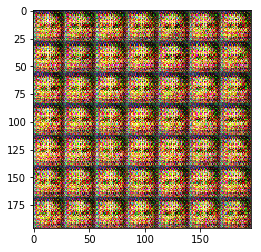

Epoch 1/1 Discriminator Loss: 0.5166 Generator Loss: 2.3214
Epoch 1/1 Discriminator Loss: 0.5614 Generator Loss: 2.0026
Epoch 1/1 Discriminator Loss: 0.5608 Generator Loss: 2.0563
Epoch 1/1 Discriminator Loss: 0.5016 Generator Loss: 2.3775
Epoch 1/1 Discriminator Loss: 0.4794 Generator Loss: 2.3880
Epoch 1/1 Discriminator Loss: 0.4988 Generator Loss: 2.3544
Epoch 1/1 Discriminator Loss: 0.4584 Generator Loss: 2.5599
Epoch 1/1 Discriminator Loss: 0.5245 Generator Loss: 2.1586
Epoch 1/1 Discriminator Loss: 0.4749 Generator Loss: 2.3246
Epoch 1/1 Discriminator Loss: 0.5008 Generator Loss: 2.2993


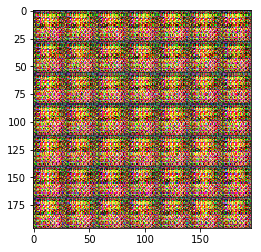

Epoch 1/1 Discriminator Loss: 0.4661 Generator Loss: 2.5232
Epoch 1/1 Discriminator Loss: 0.4652 Generator Loss: 2.5371
Epoch 1/1 Discriminator Loss: 0.4449 Generator Loss: 2.4778
Epoch 1/1 Discriminator Loss: 0.4501 Generator Loss: 2.6950
Epoch 1/1 Discriminator Loss: 0.4735 Generator Loss: 2.4204
Epoch 1/1 Discriminator Loss: 0.4925 Generator Loss: 2.5210
Epoch 1/1 Discriminator Loss: 0.5187 Generator Loss: 2.4793
Epoch 1/1 Discriminator Loss: 0.4735 Generator Loss: 2.4394
Epoch 1/1 Discriminator Loss: 0.4809 Generator Loss: 2.4879
Epoch 1/1 Discriminator Loss: 0.4708 Generator Loss: 2.6046


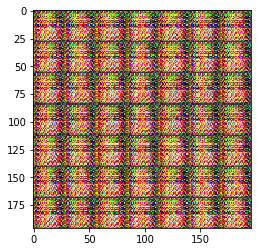

Epoch 1/1 Discriminator Loss: 0.5433 Generator Loss: 2.3546
Epoch 1/1 Discriminator Loss: 0.4573 Generator Loss: 2.4673
Epoch 1/1 Discriminator Loss: 0.4497 Generator Loss: 2.5068
Epoch 1/1 Discriminator Loss: 0.4776 Generator Loss: 2.4950
Epoch 1/1 Discriminator Loss: 0.4387 Generator Loss: 2.5785
Epoch 1/1 Discriminator Loss: 0.4893 Generator Loss: 2.4980
Epoch 1/1 Discriminator Loss: 0.4672 Generator Loss: 2.5127
Epoch 1/1 Discriminator Loss: 0.4937 Generator Loss: 2.3926
Epoch 1/1 Discriminator Loss: 0.4344 Generator Loss: 2.6668
Epoch 1/1 Discriminator Loss: 0.4606 Generator Loss: 2.4534


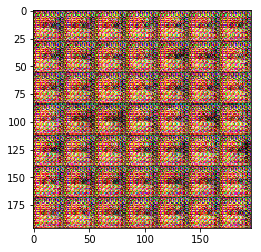

Epoch 1/1 Discriminator Loss: 0.4332 Generator Loss: 2.6660
Epoch 1/1 Discriminator Loss: 0.4780 Generator Loss: 2.4215
Epoch 1/1 Discriminator Loss: 0.4974 Generator Loss: 2.5138
Epoch 1/1 Discriminator Loss: 0.4778 Generator Loss: 2.4888
Epoch 1/1 Discriminator Loss: 0.5506 Generator Loss: 2.0212
Epoch 1/1 Discriminator Loss: 0.6569 Generator Loss: 1.7979
Epoch 1/1 Discriminator Loss: 0.5981 Generator Loss: 1.9156
Epoch 1/1 Discriminator Loss: 0.6306 Generator Loss: 1.7668
Epoch 1/1 Discriminator Loss: 0.7396 Generator Loss: 1.4687
Epoch 1/1 Discriminator Loss: 0.8297 Generator Loss: 1.5566


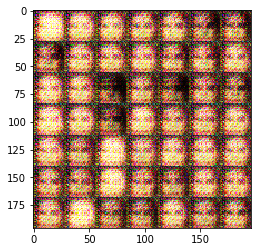

Epoch 1/1 Discriminator Loss: 0.6991 Generator Loss: 1.6097
Epoch 1/1 Discriminator Loss: 0.6564 Generator Loss: 1.7502
Epoch 1/1 Discriminator Loss: 0.6540 Generator Loss: 1.7179
Epoch 1/1 Discriminator Loss: 0.6433 Generator Loss: 1.7788
Epoch 1/1 Discriminator Loss: 0.6827 Generator Loss: 1.8310
Epoch 1/1 Discriminator Loss: 0.6620 Generator Loss: 1.7936
Epoch 1/1 Discriminator Loss: 0.6707 Generator Loss: 1.6993
Epoch 1/1 Discriminator Loss: 0.6754 Generator Loss: 1.7890
Epoch 1/1 Discriminator Loss: 0.6530 Generator Loss: 1.7536
Epoch 1/1 Discriminator Loss: 0.8081 Generator Loss: 1.4582


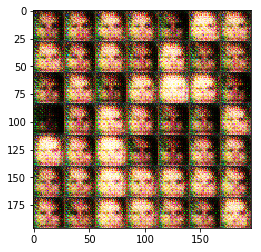

Epoch 1/1 Discriminator Loss: 0.6609 Generator Loss: 1.7444
Epoch 1/1 Discriminator Loss: 0.7702 Generator Loss: 1.5370
Epoch 1/1 Discriminator Loss: 0.6687 Generator Loss: 1.6274
Epoch 1/1 Discriminator Loss: 0.5851 Generator Loss: 1.8343
Epoch 1/1 Discriminator Loss: 0.7080 Generator Loss: 1.6518
Epoch 1/1 Discriminator Loss: 0.6973 Generator Loss: 1.8210
Epoch 1/1 Discriminator Loss: 0.6346 Generator Loss: 1.8470
Epoch 1/1 Discriminator Loss: 0.7591 Generator Loss: 1.5473
Epoch 1/1 Discriminator Loss: 0.8196 Generator Loss: 1.4528
Epoch 1/1 Discriminator Loss: 0.7400 Generator Loss: 1.5226


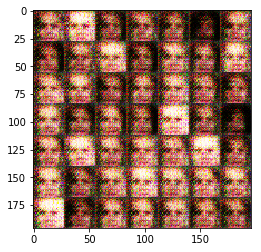

Epoch 1/1 Discriminator Loss: 0.8500 Generator Loss: 1.3341
Epoch 1/1 Discriminator Loss: 0.7905 Generator Loss: 1.5170
Epoch 1/1 Discriminator Loss: 0.8357 Generator Loss: 1.4330
Epoch 1/1 Discriminator Loss: 0.7498 Generator Loss: 1.5331
Epoch 1/1 Discriminator Loss: 0.7546 Generator Loss: 1.4590
Epoch 1/1 Discriminator Loss: 0.9602 Generator Loss: 1.2339
Epoch 1/1 Discriminator Loss: 0.8811 Generator Loss: 1.4264
Epoch 1/1 Discriminator Loss: 0.7431 Generator Loss: 1.5561
Epoch 1/1 Discriminator Loss: 0.8507 Generator Loss: 1.3733
Epoch 1/1 Discriminator Loss: 0.9470 Generator Loss: 1.2429


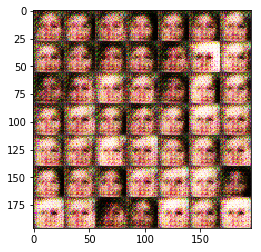

Epoch 1/1 Discriminator Loss: 0.8441 Generator Loss: 1.3461
Epoch 1/1 Discriminator Loss: 0.7527 Generator Loss: 1.6662
Epoch 1/1 Discriminator Loss: 0.8306 Generator Loss: 1.3545
Epoch 1/1 Discriminator Loss: 0.9714 Generator Loss: 1.2217
Epoch 1/1 Discriminator Loss: 0.8718 Generator Loss: 1.3352
Epoch 1/1 Discriminator Loss: 0.8371 Generator Loss: 1.4376
Epoch 1/1 Discriminator Loss: 1.0402 Generator Loss: 1.1665
Epoch 1/1 Discriminator Loss: 0.8930 Generator Loss: 1.2914
Epoch 1/1 Discriminator Loss: 0.8365 Generator Loss: 1.3893
Epoch 1/1 Discriminator Loss: 0.8082 Generator Loss: 1.3885


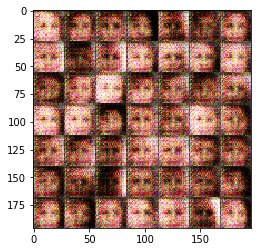

Epoch 1/1 Discriminator Loss: 0.9524 Generator Loss: 1.3345
Epoch 1/1 Discriminator Loss: 0.9038 Generator Loss: 1.3087
Epoch 1/1 Discriminator Loss: 0.9719 Generator Loss: 1.3395
Epoch 1/1 Discriminator Loss: 0.8737 Generator Loss: 1.3652
Epoch 1/1 Discriminator Loss: 0.9179 Generator Loss: 1.2380
Epoch 1/1 Discriminator Loss: 0.9663 Generator Loss: 1.2407
Epoch 1/1 Discriminator Loss: 0.8725 Generator Loss: 1.3608
Epoch 1/1 Discriminator Loss: 0.9681 Generator Loss: 1.2496
Epoch 1/1 Discriminator Loss: 0.9175 Generator Loss: 1.2253
Epoch 1/1 Discriminator Loss: 0.8760 Generator Loss: 1.3165


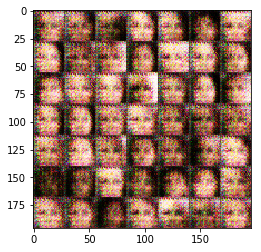

Epoch 1/1 Discriminator Loss: 0.9313 Generator Loss: 1.1939
Epoch 1/1 Discriminator Loss: 0.9998 Generator Loss: 1.1545
Epoch 1/1 Discriminator Loss: 1.1374 Generator Loss: 1.0301
Epoch 1/1 Discriminator Loss: 0.9945 Generator Loss: 1.1809
Epoch 1/1 Discriminator Loss: 1.1849 Generator Loss: 1.0020
Epoch 1/1 Discriminator Loss: 1.0388 Generator Loss: 1.2129
Epoch 1/1 Discriminator Loss: 1.1663 Generator Loss: 1.0609
Epoch 1/1 Discriminator Loss: 1.0625 Generator Loss: 1.0841
Epoch 1/1 Discriminator Loss: 1.0536 Generator Loss: 1.1852
Epoch 1/1 Discriminator Loss: 1.1299 Generator Loss: 1.0509


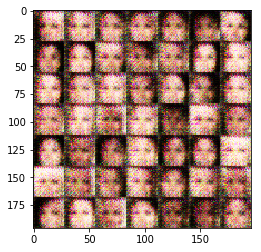

Epoch 1/1 Discriminator Loss: 1.0072 Generator Loss: 1.0996
Epoch 1/1 Discriminator Loss: 1.0051 Generator Loss: 1.1200
Epoch 1/1 Discriminator Loss: 1.0539 Generator Loss: 1.1057
Epoch 1/1 Discriminator Loss: 1.0952 Generator Loss: 1.0472
Epoch 1/1 Discriminator Loss: 0.9435 Generator Loss: 1.1480
Epoch 1/1 Discriminator Loss: 1.0130 Generator Loss: 1.1803
Epoch 1/1 Discriminator Loss: 1.0359 Generator Loss: 1.1142
Epoch 1/1 Discriminator Loss: 1.1440 Generator Loss: 0.9142


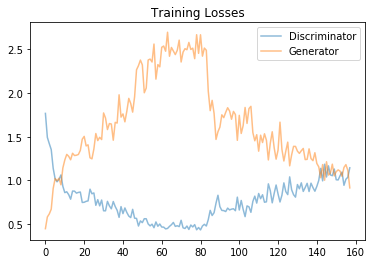

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.00001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.